In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
%matplotlib notebook
from main import *

In [2]:
#Extracting the SS coverages previously saved and extracted from kMC files
ss_COVG_NONLAT = pd.read_csv('SS_Covg_nonLat.csv')
ss_COVG_LAT = pd.read_csv('SS_Covg_Lat.csv')

In [3]:
#Isolating pressures and ss coverages
Prs_non_lat = ss_COVG_NONLAT.iloc[:,0].to_numpy()
Prs_lat = ss_COVG_LAT.iloc[:,0].to_numpy()
ss_covg_non_lat = ss_COVG_NONLAT.iloc[:,1].to_numpy()
ss_covg_lat = ss_COVG_LAT.iloc[:,1].to_numpy()

In [4]:
#Simulation times from each kMC simulation
t0,tf = 0,750.000000000102

In [5]:
%%time
#Performing SS MIKI MKM simulations for non lateral case
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(t0,tf)
MKM.rate_const_correction='None'
MKM_SS_covg_NONLAT = []
Prs = Prs_non_lat
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_NONLAT = np.append(MKM_SS_covg_NONLAT,MKM.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 3.44 s, sys: 66.1 ms, total: 3.5 s
Wall time: 3.67 s


<IPython.core.display.Javascript object>


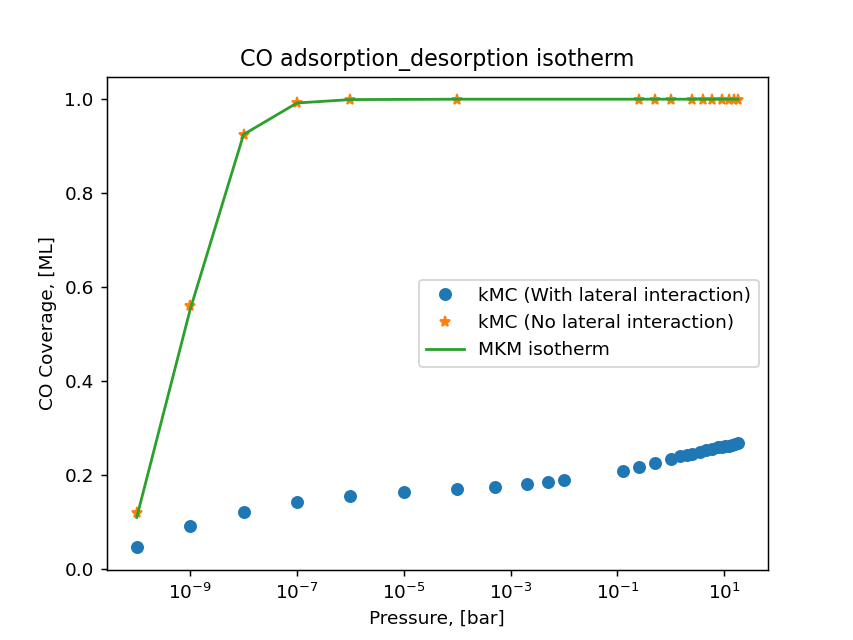

In [6]:
plt.figure()
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

In [7]:
# For lateral only
##Step 1: Calculating Ki based on isotherm equation
Ki_lateral = []
for i in np.arange(len(Prs_lat)):
    Ki_lateral.append(ss_covg_lat[i]/((1-ss_covg_lat[i]) * Prs_lat[i]))
    
##Step 2: Calculating fi(theta)
Keq = MKM.k[0]/MKM.k[1]
fi_theta = []
for i in np.arange(len(Prs_lat)):
    fi_theta.append(Ki_lateral[i]/Keq)
    
##Therefore need to train ML model (for lateral interactions considered) where x is theta and y is fi_theta
##Step 3: MLM model
print('For Lateral:\n')
print('Pressure, SS_coverage_CO, K_from_isoeqn, f(theta)')
print(np.array([Prs_lat,ss_covg_lat,Ki_lateral,fi_theta]).T)

For Lateral:

Pressure, SS_coverage_CO, K_from_isoeqn, f(theta)
[[1.00000000e-10 4.63296155e-02 4.85803232e+08 3.94275087e-01]
 [1.00000000e-09 9.11109711e-02 1.00244329e+08 8.13577165e-02]
 [1.00000000e-08 1.21996393e-01 1.38947485e+07 1.12768973e-02]
 [1.00000000e-07 1.43216148e-01 1.67155517e+06 1.35662448e-03]
 [1.00000000e-06 1.55425457e-01 1.84028110e+05 1.49356148e-04]
 [1.00000000e-05 1.63325156e-01 1.95207442e+04 1.58429228e-05]
 [1.00000000e-04 1.70388884e-01 2.05384042e+03 1.66688498e-06]
 [5.00000000e-04 1.75406734e-01 4.25438192e+02 3.45283170e-07]
 [2.00000000e-03 1.80016145e-01 1.09768104e+02 8.90871566e-08]
 [5.00000000e-03 1.84291328e-01 4.51855752e+01 3.66723509e-08]
 [1.00000000e-02 1.88856113e-01 2.32826895e+01 1.88960958e-08]
 [1.25000000e-01 2.08986241e-01 2.11360411e+00 1.71538884e-09]
 [2.50000000e-01 2.17408512e-01 1.11122350e+00 9.01862547e-10]
 [5.00000000e-01 2.25479268e-01 5.82242045e-01 4.72544269e-10]
 [1.00000000e+00 2.34419844e-01 3.06198955e-01 2.48509

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sympy import *
from sklearn.utils.random import check_random_state
import graphviz
import time

In [9]:
data = np.array([ss_covg_lat, fi_theta]).T
columns = ['theta', 'f(theta)']
df = pd.DataFrame(data = data, columns = columns)
df.head()

,theta,f(theta)
0,0.046330,0.394275
1,0.091111,0.081358
2,0.121996,0.011277
3,0.143216,0.001357
4,0.155425,0.000149


<IPython.core.display.Javascript object>


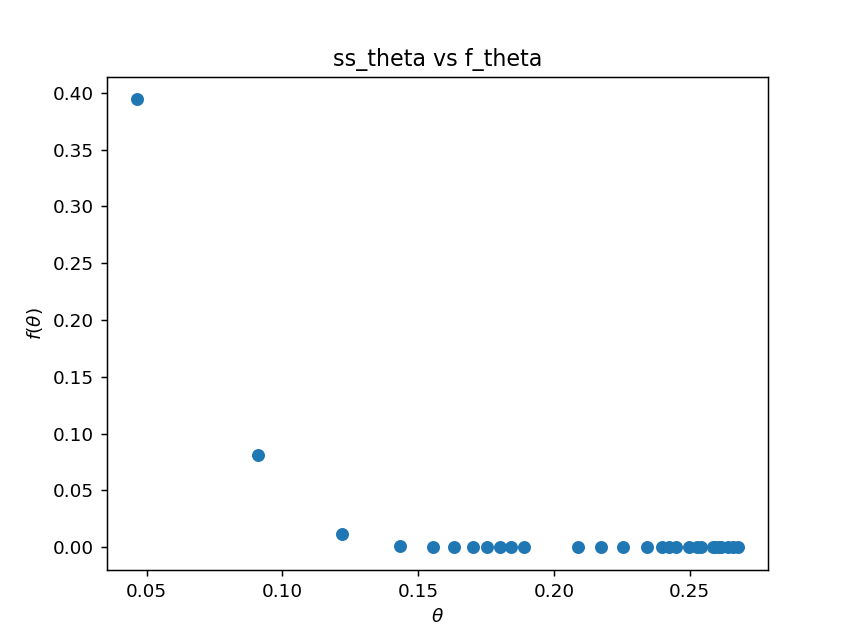

Text(0.5, 0, '$\\theta$')

In [10]:
plt.figure(dpi = 100)
plt.title('ss_theta vs f_theta')
plt.scatter(df['theta'], df['f(theta)'])
plt.ylabel(r'$f(\theta)$')
plt.xlabel(r'$\theta$')

In [11]:
#### Scaling the data to avoid skewed data aligning with zero -> leading to a zero function
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
# scaler = MinMaxScaler()
# scaler.fit(np.array(Ki_lateral).reshape(-1, 1))
# Ki_lateral = scaler.transform(np.array(Ki_lateral).reshape(-1, 1))
# data = np.array([ss_covg_lat, Ki_lateral[:,0]]).T
# columns = ['theta', 'f(theta)']
# df = pd.DataFrame(data = data, columns = columns)
# df.head()

fi_Final = []
for i in np.arange(len(fi_theta)):
    fi_Final.append(fi_theta[i]*1e6)
    
fi_Final = np.array(fi_Final).reshape(-1,)    
data = np.array([ss_covg_lat, fi_Final]).T
columns = ['theta', 'f(theta)']
df = pd.DataFrame(data = data, columns = columns)
df.head()

,theta,f(theta)
0,0.046330,394275.087170
1,0.091111,81357.716508
2,0.121996,11276.897328
3,0.143216,1356.624484
4,0.155425,149.356148


<IPython.core.display.Javascript object>


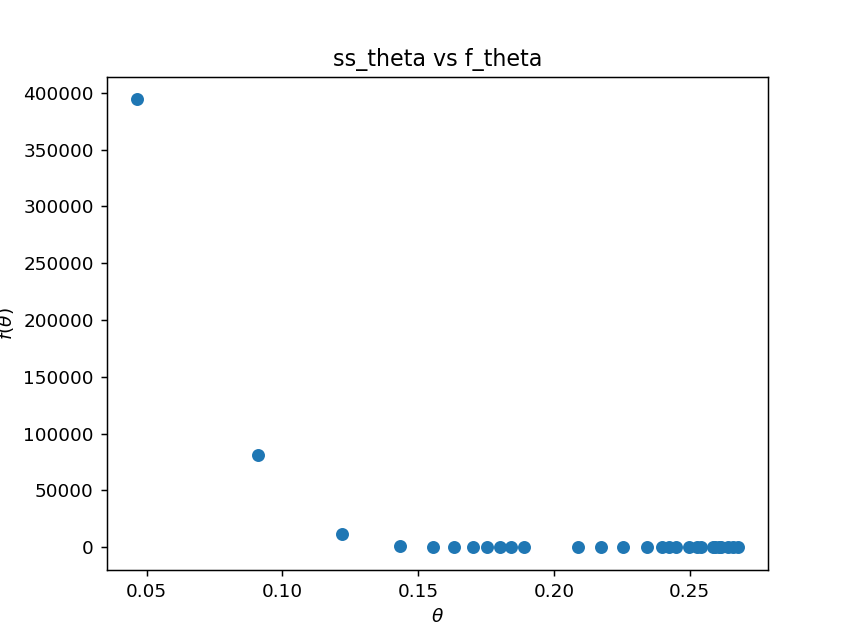

Text(0.5, 0, '$\\theta$')

In [12]:
plt.figure(dpi = 100)
plt.title('ss_theta vs f_theta')
plt.scatter(df['theta'], df['f(theta)'])
plt.ylabel(r'$f(\theta)$')
plt.xlabel(r'$\theta$')

In [13]:
X = df[['theta']]
y = df['f(theta)']
y_true = y
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.40, random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16, 1), (12, 1), (16,), (12,))

In [14]:
function_set = ['log','mul','add','sub']


In [15]:
est_gp = SymbolicRegressor(population_size=500000,function_set=function_set,const_range=(0.0,0.0),
                           generations=40, stopping_criteria=0.01,metric='rmse',
                           p_crossover=0.85, p_subtree_mutation=0.05, ##
                           p_hoist_mutation=0.05, p_point_mutation=0.05, ##need to add up to 1
                           max_samples=0.8, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

In [16]:
t0 = time.time()
est_gp.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    28.02          85424.1       91         0.026642           197139    242.06m
   1    24.89          85408.4       38        0.0282941           197139    227.13m
   2    23.08          85452.2       15        0.0281092           197139    222.27m
   3    22.34          85392.5        9        0.0283409           197139    290.52m
   4    23.14          85489.8       22        0.0273131           197139    485.38m
   5    25.21          85291.1        9        0.0170859           197139    279.23m
   6    28.56          85505.2       29        0.0281092           197139    324.26m
   7    33.79          85416.7       97        0.0280193           197139    351.24m
   8    40.32          85409.5       11        0.0283409           197139  

In [17]:
t0 = time.time()
y_gp1 = est_gp.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

Time to predict: 0.13236308097839355 seconds


In [18]:
score_gp1 = est_gp.score(X_test, y_test)
print('R2:', score_gp1)

R2: -0.11861376568852733


In [19]:
converter = {
    'add': lambda x, y : x + y,
    'sub': lambda x, y : x - y,
    'mul': lambda x, y : x*y,
    'div': lambda x, y : x/y,
    'sqrt': lambda x : x**0.5,
    'log': lambda x : log(x),
    'abs': lambda x : abs(x),
    'neg': lambda x : -x,
    'inv': lambda x : 1/x,
    'max': lambda x, y : max(x, y),
    'min': lambda x, y : min(x, y),
    'sin': lambda x : sin(x),
    'cos': lambda x : cos(x),
    'pow': lambda x, y : x**y,
}

In [20]:
next_e = sympify(str(est_gp._program), locals=converter)
next_e

nan

In [21]:
y_gp = est_gp.predict(X_test)
score_gp1 = est_gp.score(X_test, y_test)
score_gp1

-0.11861376568852733

<IPython.core.display.Javascript object>


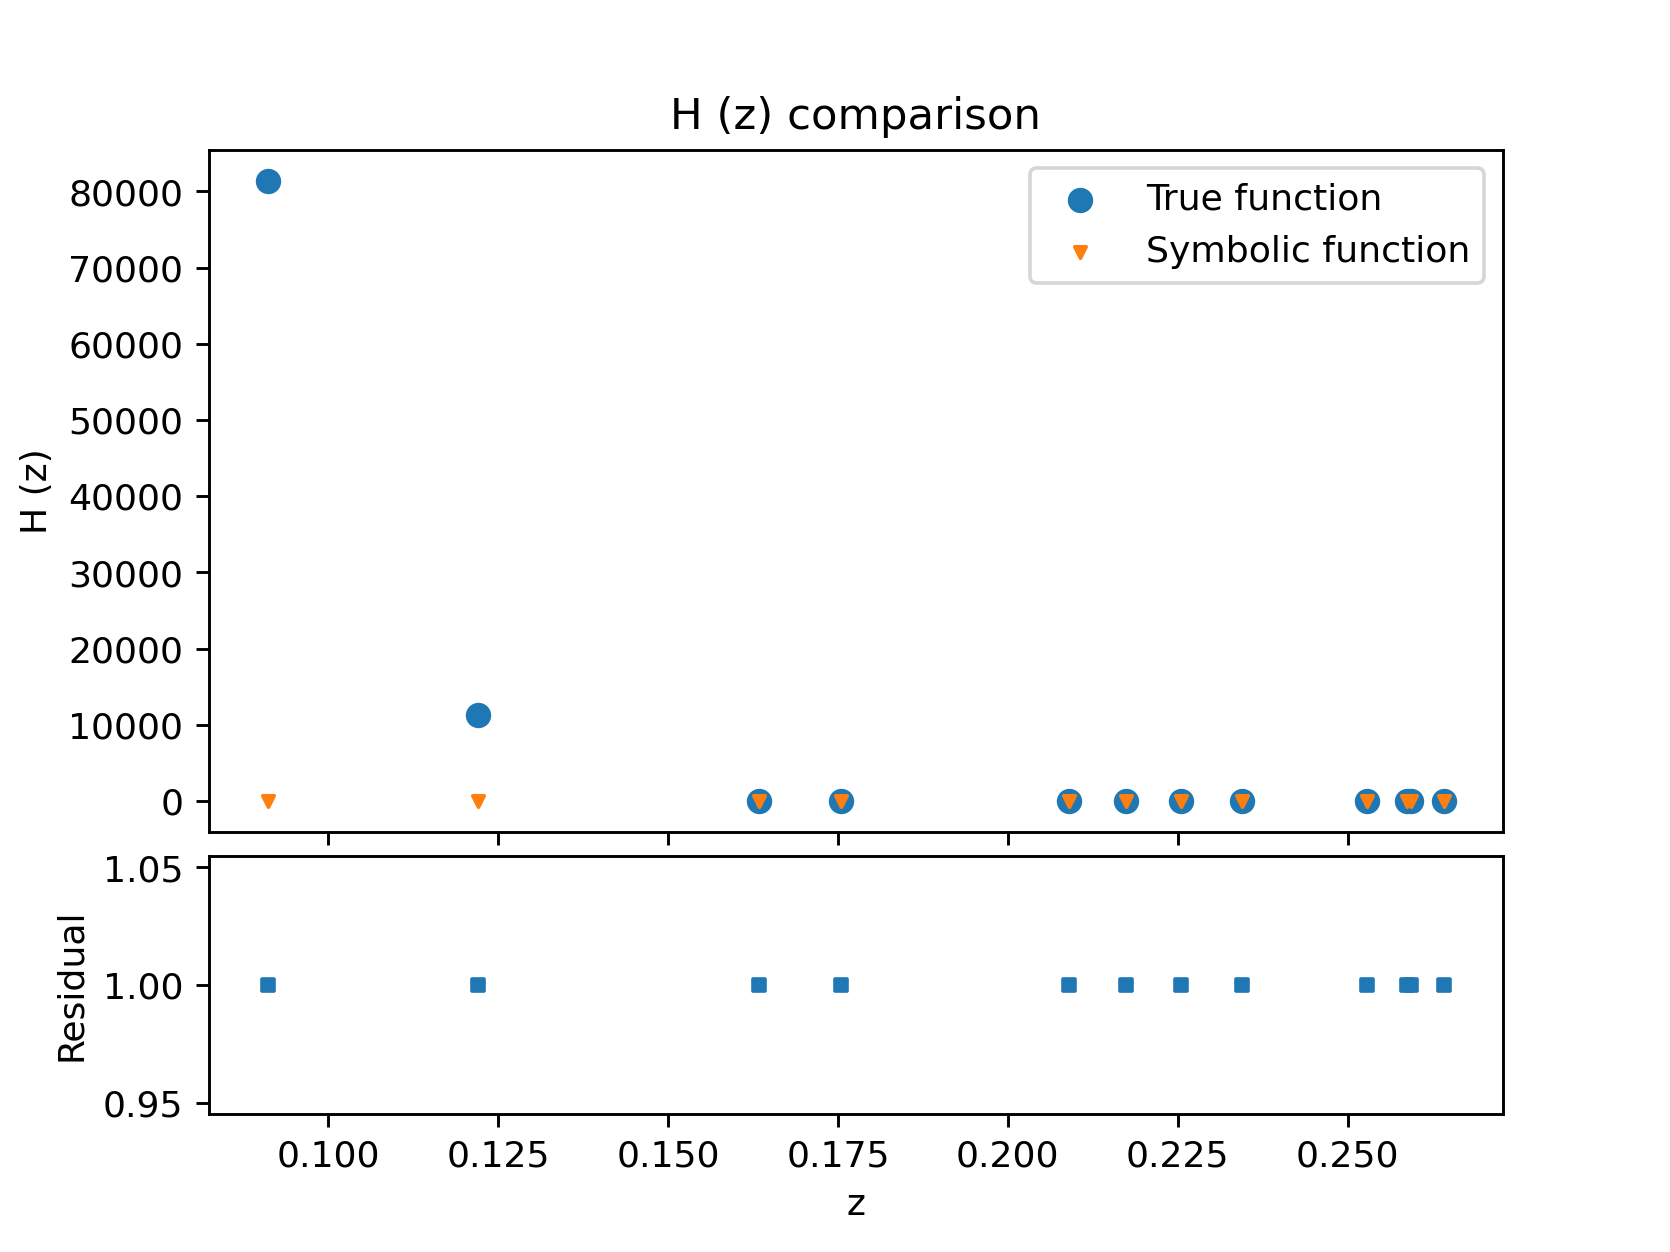

Text(0.5, 0, 'z')

In [22]:
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test, y_test, label = 'True function')
plt.scatter(X_test, y_gp1, marker = 'v', s = 10, label = 'Symbolic function')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test, 1. - y_gp1/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

In [23]:
#Simulation times from each kMC simulation
t0,tf = 0,750.000000000102

In [24]:
%%time
#Performing SS MIKI MKM simulations for lateral case
from main import *
MKMCD = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKMCD.Thermo_Constraint = 'OFF'
MKMCD.set_limits_of_integration(t0,tf)
colmn = len(MKMCD.Stoich.iloc[0,1:]) - len(MKMCD.P) #Number of columns (i.e rate coefficients = no. of surface species being investigated)
row = len(MKMCD.k) #number of rows = number of rate constants (i.e reaction steps)
MKM_SS_covg_LAT = []
Prs = Prs_lat #Lateral pressures## TO BE PREDICTED###########################################################
for i in np.arange(len(Prs)):
    MKMCD.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKMCD.get_SS_coverages(print_warning=True)[0])    

Mass is conserved. 

Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
CPU times: user 4.81 s, sys: 83 ms, total: 4.89 s
Wall time: 7.06 s


In [25]:
##Step 4-> Getting predicted _f(theta)
f_theta_pred = est_gp.predict(np.array([MKM_SS_covg_LAT]).T)
# f_theta_pred = np.exp(0.03483852*(MKM_SS_covg_LAT**3))
# f_theta_pred = np.exp(-MKM_SS_covg_LAT)-np.exp(MKM_SS_covg_LAT)

##Step 5-> Recalculating Ki_lateral from Keq : f = Ki/Keq
Ki_lateral_pred = []
for i in np.arange(len(Prs)):
    Ki_lateral_pred.append(f_theta_pred[i]*Keq)

##Step6-> Calculating predicted theta
ML_theta_pred = []
for i in np.arange(len(Prs)):
    ML_theta_pred.append((Ki_lateral_pred[i]*Prs[i])/(1+(Ki_lateral_pred[i]*Prs[i])))

<IPython.core.display.Javascript object>


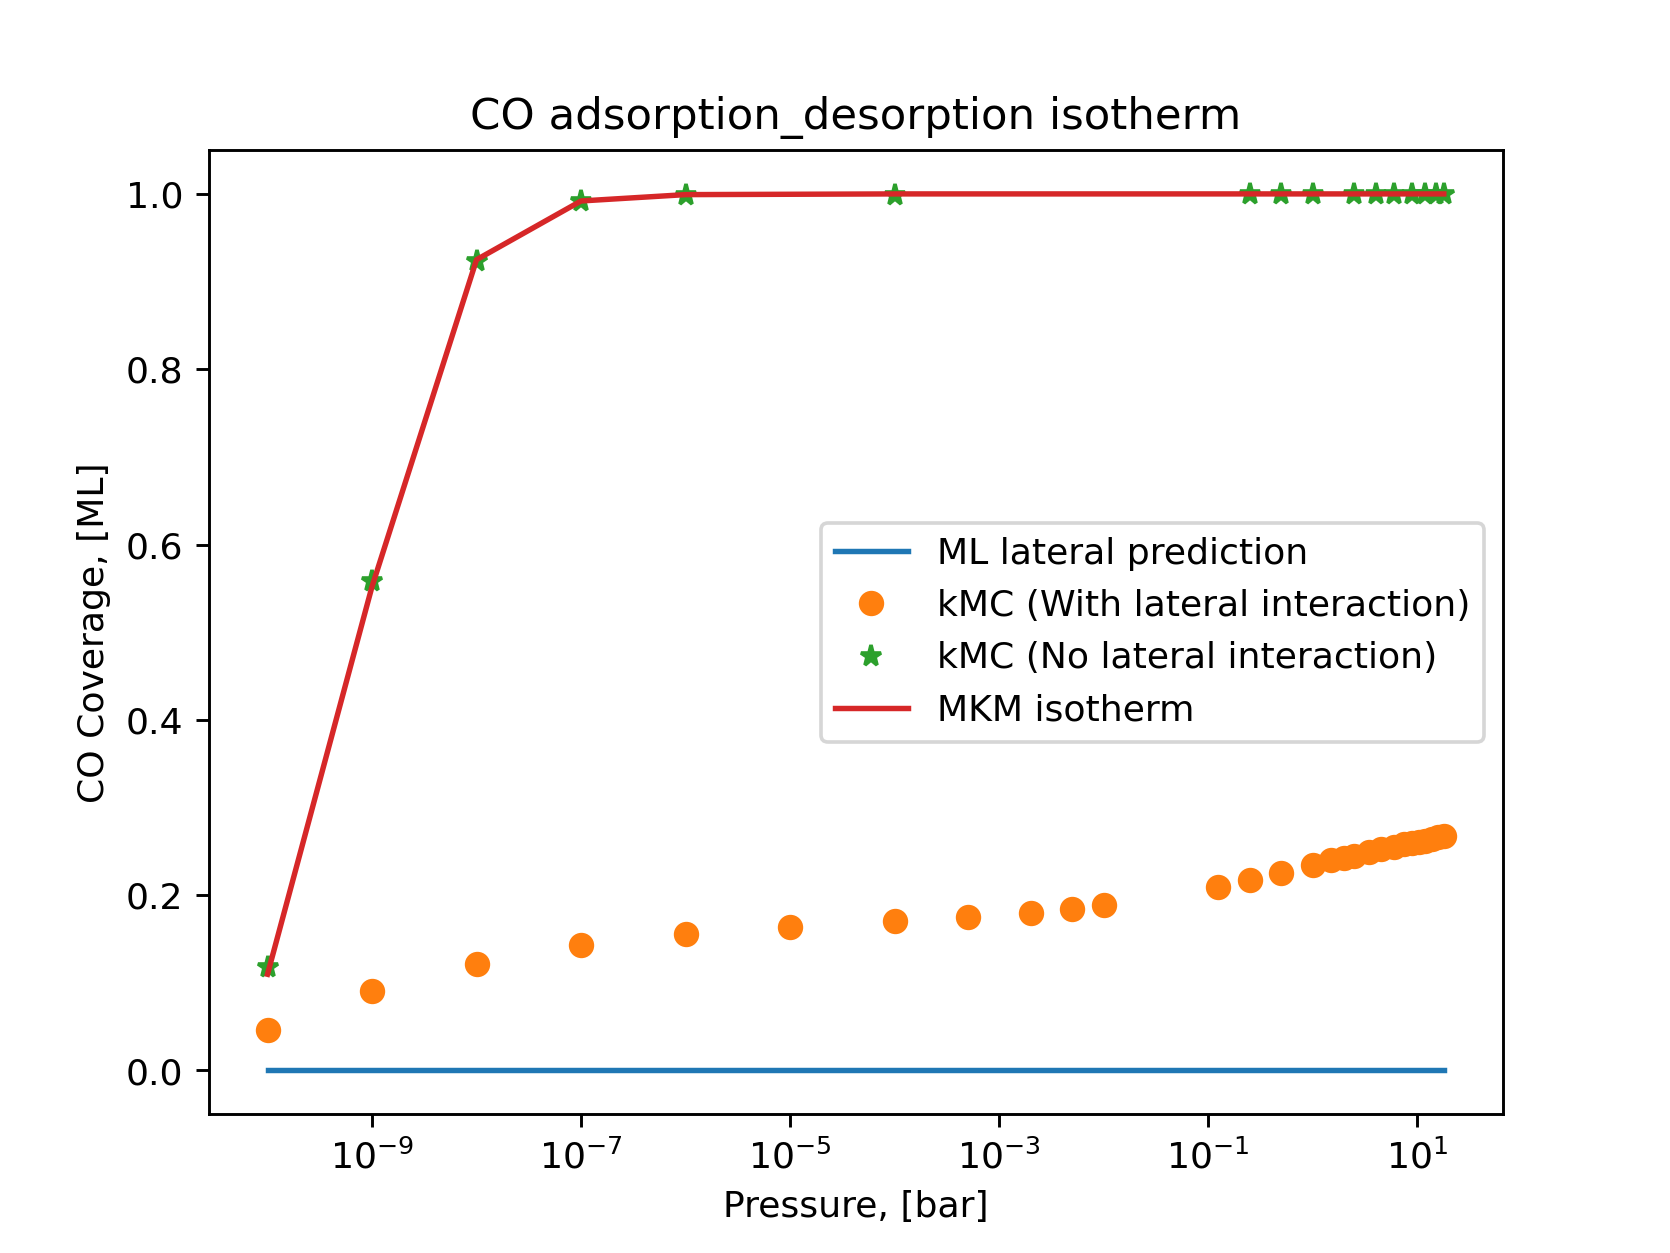

In [26]:
plt.figure()
plt.semilogx(Prs,ML_theta_pred,'-',label='ML lateral prediction')
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

<IPython.core.display.Javascript object>


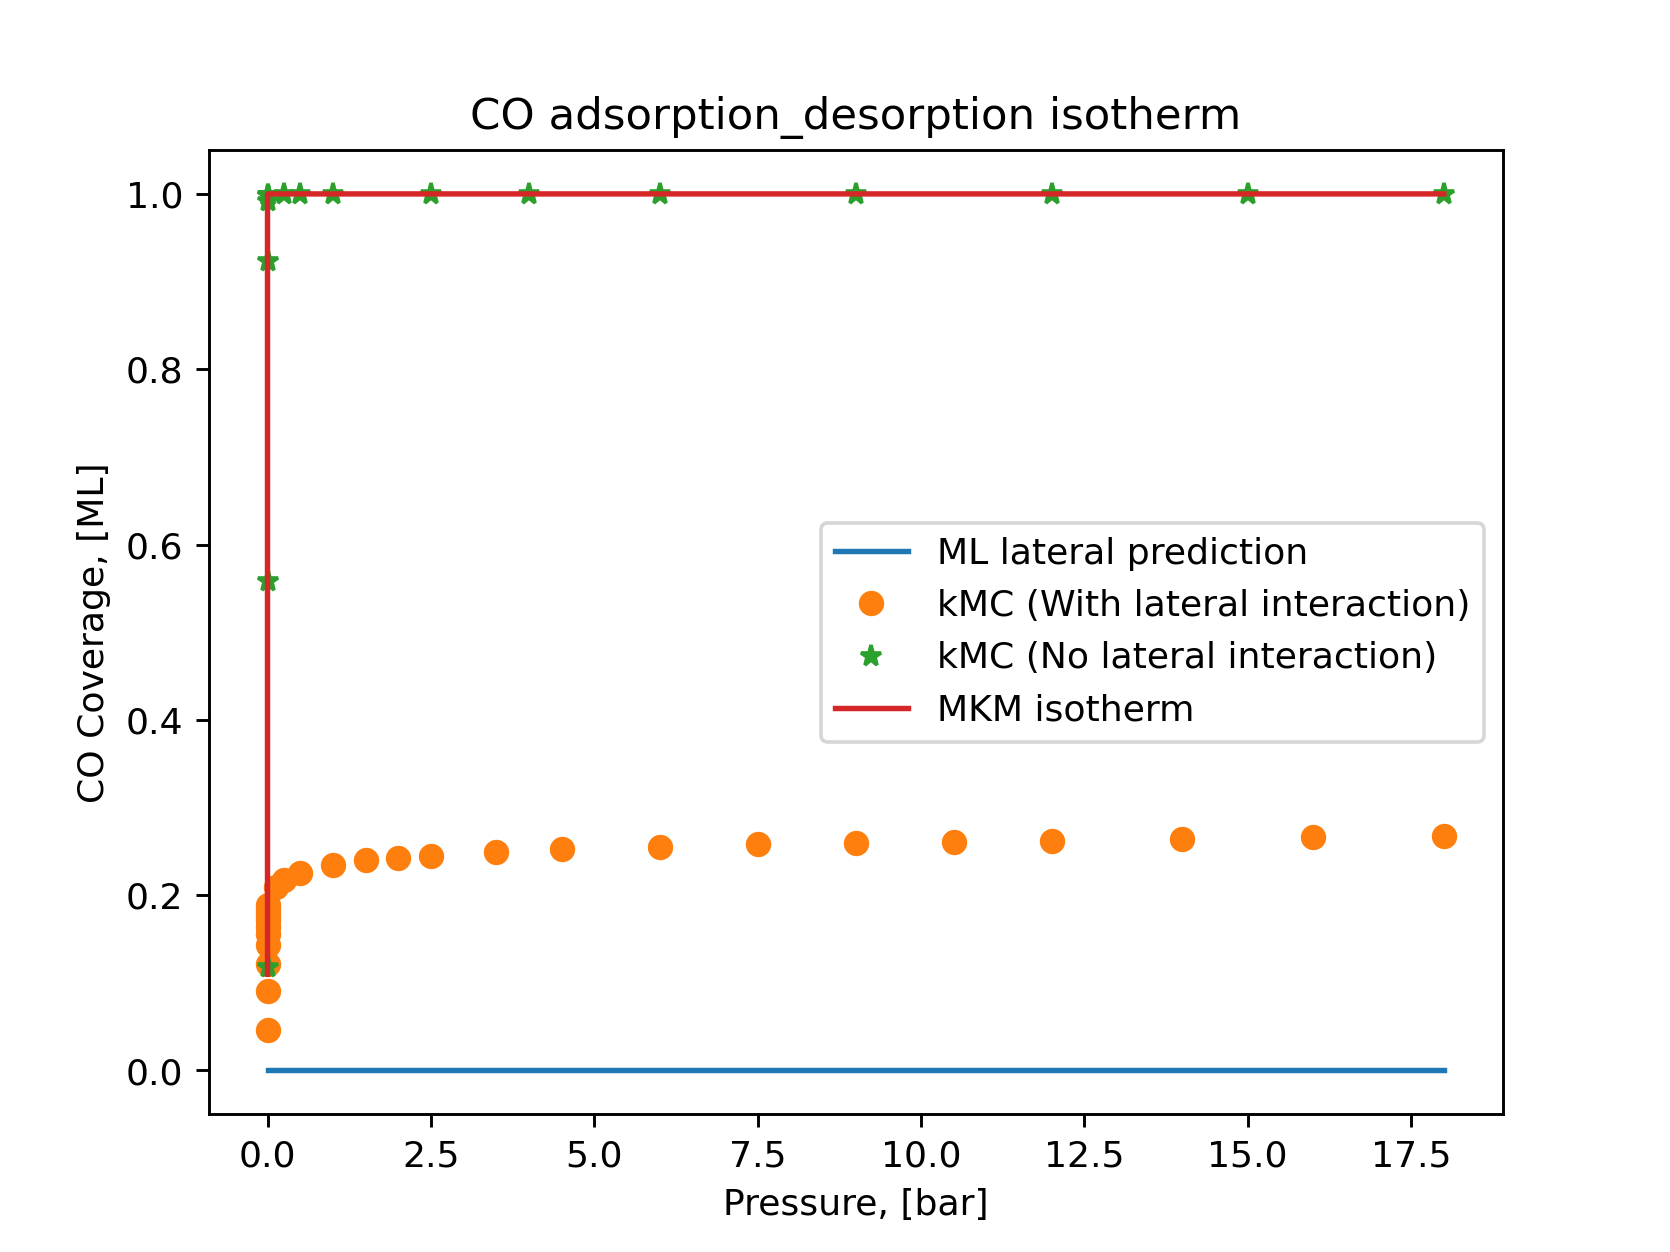

In [27]:
plt.figure()
plt.plot(Prs,ML_theta_pred,'-',label='ML lateral prediction')
plt.plot(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.plot(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.plot(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()